# Library

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from utils.msi_object import msi
from utils.basic_utils import return_candidate_peaks
from utils.validation_tests import *

plt.style.use('seaborn-v0_8')  # Changed style

# Starting up

## Load Data

In [3]:
obj = msi('data/M2')

## Determine Insulin m/z values

### Plot m/z

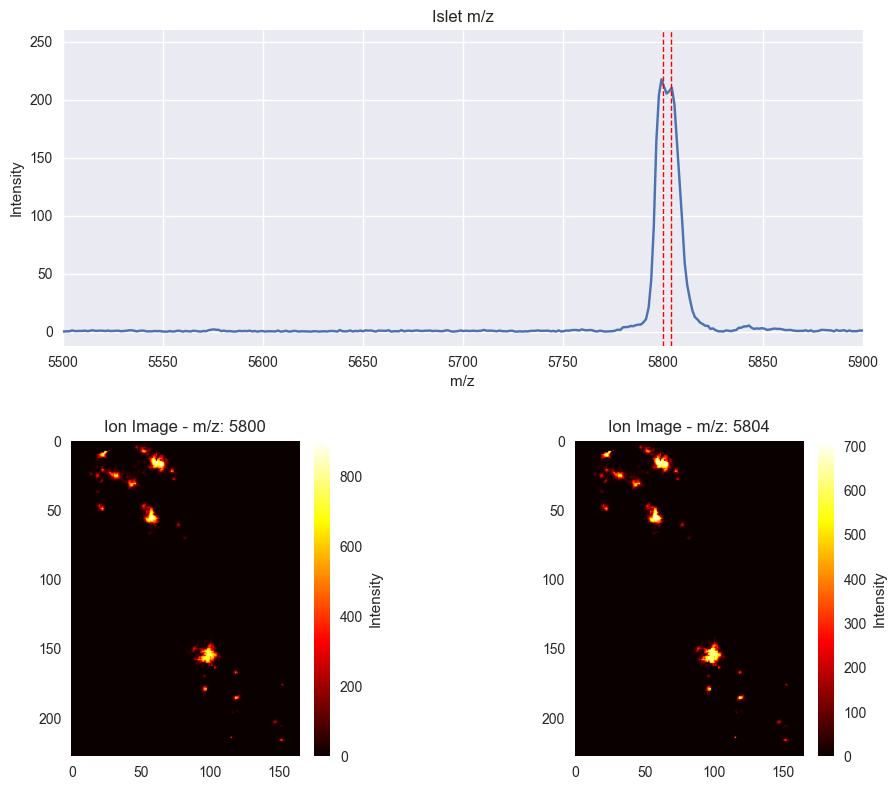

In [4]:
obj.plot_islet_mz(vertical_1 = 5800, vertical_2 = 5804, x_limit = [5500, 5900], larger_than = 200, set_mz = True)

### Set m/z

In [5]:
obj.set_insulin(insulin_1_mz = 5800, insulin_2_mz = 5804)

# Chapter 4 - Pearson Correlation

## Find Threshold

In [6]:
obj.find_minimum_variance_correlation()

Minimum variance: 0.073, index: 13995
Min Variance m/z correlation with $Ins2$: 0.0263
Min Varaince m/z correlation with $Ins1$: 0.0274


## Apply Pearson

In [7]:
obj.pearson_correlation(plot = False)

## Divide into Clusters -- Easier to handle

In [8]:
obj.create_clusters(k = 3, plot = False) # chunk_peak_mz, chunk_peak_n, chunk_mz, chunk_corr_1, chunk_corr_2

/Users/Serkan/opt/anaconda3/envs/thesis_final/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Find the source of correlated m/z 

### Method 1 - Finding Peaks

In [9]:
obj.find_peaks(height=0.3, distance=None, plot = False)

### Method 2 - Mixture of Gaussians

#### Find the optimum number of gaussians for each chunk

In [9]:
# obj.prepare_gaussian_mixture(n_component_max = 50, n_repeat_experiment= 30, max_iter = 100, n_init = 10, covariance_type = 'diag', plot = False, vertical_line = 10)

#### Apply the mixture of gaussian with given #components

In [10]:
n_mix_gaussians = [13, 37, 2]
obj.fit_gaussian_mixture(n_components = n_mix_gaussians, plot = False)

### Method 3 - Finding Peaks with Filter

#### Determine Peaks

In [11]:
obj.find_peak_filter(chunk = 0, interp1d_kind = 'cubic', filter_window_length = 5, filter_polyorder = 2, 
                     find_peaks_height = 0.1, find_peaks_distance = None, find_peaks_threshold = 0.00001, plot = False)

In [12]:
obj.find_peak_filter(chunk = 1, interp1d_kind = 'cubic', filter_window_length = 5, filter_polyorder = 3, 
                     find_peaks_height = 0.1, find_peaks_distance = 15, find_peaks_threshold = 0.00001, plot = False)

In [13]:
obj.find_peak_filter(chunk = 2, interp1d_kind = 'cubic', filter_window_length = 10, filter_polyorder = 3, 
                     find_peaks_height = 0.1, find_peaks_distance = None, find_peaks_threshold = 0.00001, plot = False)

#### Fit mixture of gaussians given the peaks

In [14]:
obj.fit_known_gaussian_mixture(plot = False)

In [15]:
obj.get_all_peaks()

Make sure you run find peak filter for each chunk!


In [16]:
random_gmm, known_means_gmm = return_candidate_peaks(obj, plot = False)

# Chapter - 6 Validation and Evaluation

In [17]:
sliding_window_candidates = np.load('data/sliding_window_candidates_spearman.npy') # outputs of Chapter 5

## Chapter 6.1 Spatial Distribution

for a given map, check whether x m/z significantly different than insulin

In [18]:
random_gmm_significant, random_gmm_non_significant = find_significant_peaks(obj, random_gmm, alpha = 0.01, parametric = False, verbose = False)
known_means_gmm_significant, known_means_gmm_non_significant = find_significant_peaks(obj, known_means_gmm, alpha = 0.01, parametric = False, verbose = False)
sliding_window_candidates_significant, sliding_window_candidates_non_significant = find_significant_peaks(obj, sliding_window_candidates, alpha = 0.01, parametric = False, verbose = False)

## Chapter 6.2 Compare Outputs of the Models

In [19]:
delta = 10
all_candidates, candidates_final = compare_output_candidate(random_gmm_significant, 
                                            known_means_gmm_significant, 
                                            sliding_window_candidates_significant, 
                                            delta = delta, verbose = False)

## Removal of the Candidates

In [20]:
islet_original, islet_removed = remove_artefacts(obj, candidates_final, plot = False)

## UMAP Analysis

### All Data - Classify by the Map

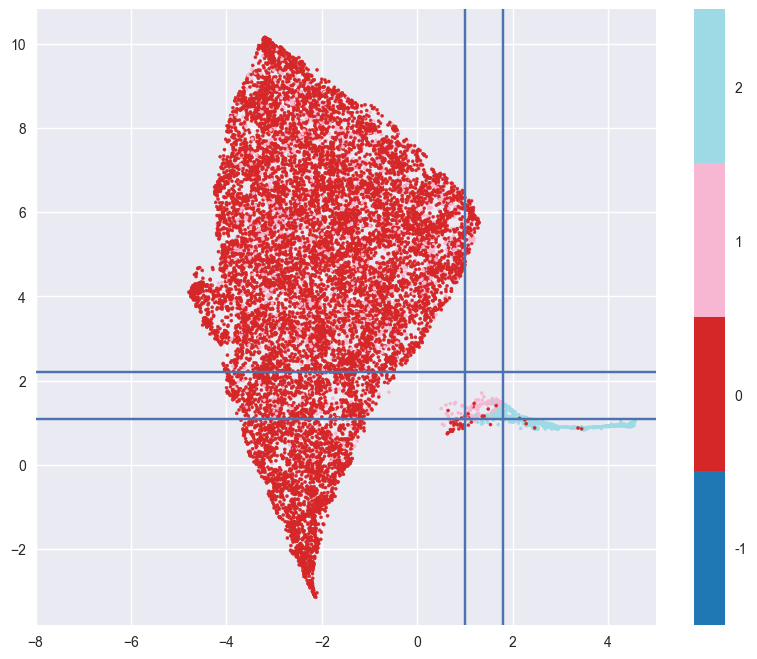

In [21]:
embedding, labels, unusual_map = umap_all_data(obj, plot = True, area_x = (1, 1.8), area_y = (1.1, 2.2))

In [22]:
# adjust area_x area_y
area_x = (1, 1.8)
area_y = (1.1, 2.2)

### Islet

In [22]:
islet_pixel_original, islet_pixel_removed, islet_pixel_label = umap_islet(obj, islet_original, islet_removed, pixel = True, plot = False)

In [23]:
islet_mz_original, islet_mz_removed, islet_mz_label = umap_islet(obj, islet_original, islet_removed, pixel = False, plot = False)

In [23]:
import matplotlib.colors as mcolors
import umap

def create_colours(data_3d):
    # define 3D color space
    norm_R = mcolors.Normalize(vmin=0, vmax=255)
    norm_G = mcolors.Normalize(vmin=0, vmax=255)
    norm_B = mcolors.Normalize(vmin=0, vmax=255)

    norm_R.autoscale(data_3d[:, 0])
    norm_G.autoscale(data_3d[:, 1])
    norm_B.autoscale(data_3d[:, 2])

    norm_embedding = list(zip(norm_R(data_3d)[:, 0], norm_G(data_3d)[:, 1], norm_B(data_3d)[:, 2]))
    
    return norm_embedding

def umap_non_islet(obj, plot = True):
    data_all = obj.data.copy()
    data_all = data_all.reshape(14000,-1).T

    np.random.seed(0)
    redu = umap.UMAP(n_components = 3)
    embedding_all = redu.fit_transform(data_all)
    res2d_all = create_colours(embedding_all)
    umap_all = np.array(res2d_all).reshape(228, 165, 3)
    umap_all[obj.cluster_map_altered == -1] = 0


    data_nonislet = obj.data.copy()
    data_nonislet[:,obj.cluster_map_altered == 1] = 0
    data_nonislet = data_nonislet.reshape(14000,-1).T

    np.random.seed(0)
    embedding_non_islet = redu.fit_transform(data_nonislet)
    res2d_non_islet = create_colours(embedding_non_islet)
    umap_non = np.array(res2d_non_islet).reshape(228, 165, 3)
    umap_non[obj.cluster_map_altered == 1] = 0
    umap_non[obj.cluster_map_altered == -1] = 0

    if plot:
        plt.grid(False)
        plt.imshow(umap_all)
        plt.show()
        plt.grid(False)
        plt.imshow(umap_non)
        plt.show()
    return umap_all, umap_non

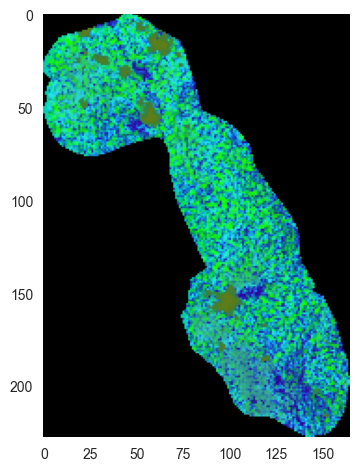

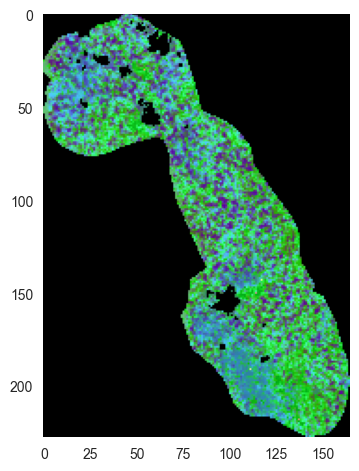

In [25]:
umap_all, umap_non = umap_non_islet(obj, plot = True)

# Figures

## Chapter 2

### Figure 2.5

Ion Image of m/z = 5800

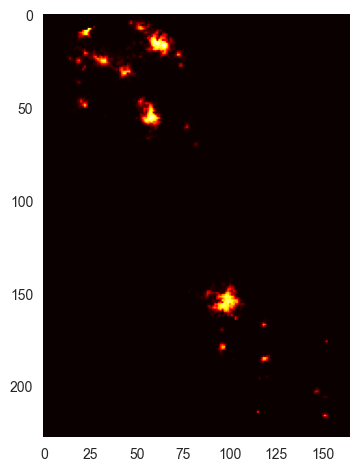

In [63]:
obj.plot_ion_image(mz = 5800) 

Ion Image of m/z = 2000

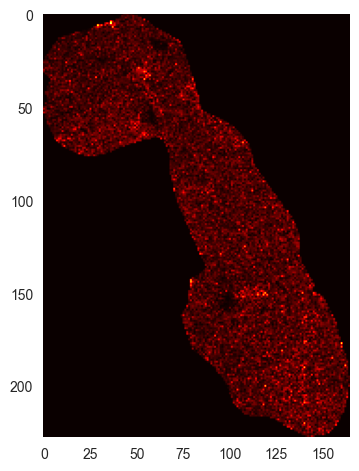

In [62]:
obj.plot_ion_image(mz = 2000)

## Chapter 3

### Figure 3.1

Determination of m/z ratios of Ins1 and Ins2. m/z intensities of a pixel within the Islet of Langerhans (top) and the corresponding ion image of the candidateinsulin m/z ratios 5800 (bottom left), and 5804 (bottom right).


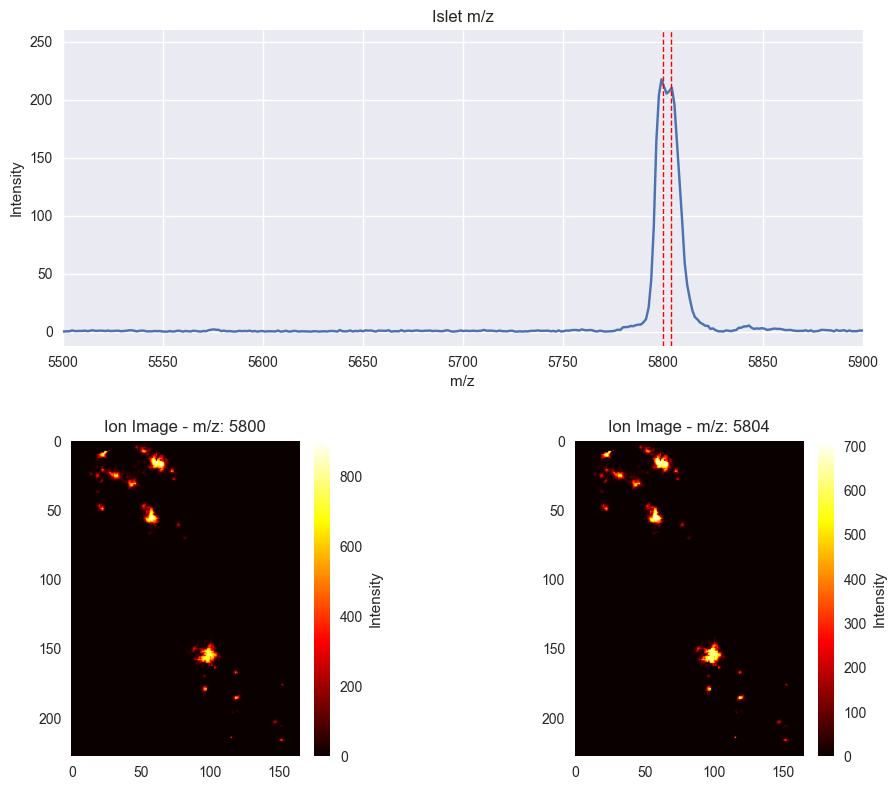

In [65]:
obj.plot_islet_mz(vertical_1 = 5800, vertical_2 = 5804, x_limit = [5500, 5900], larger_than = 200, set_mz = True)

## Chapter 4

### Figure 4.1

Ion image of $m/z$ = 20005. The $m/z$ ratio of 20005 has the least variance
$\sigma^2$ = 0.073

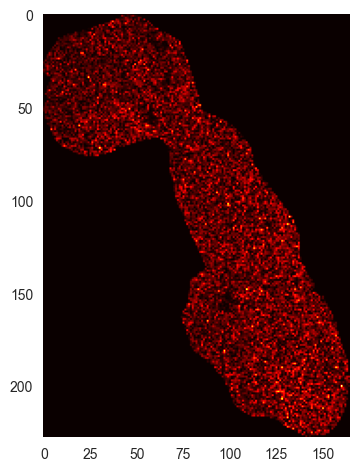

In [24]:
obj.plot_ion_image(mz = 20005)

### Figure 4.2

$m/z$ Ratios Significantly Correlated with $Ins2$. Correlated $m/z$ ratios
are plotted against the correlation coefficient

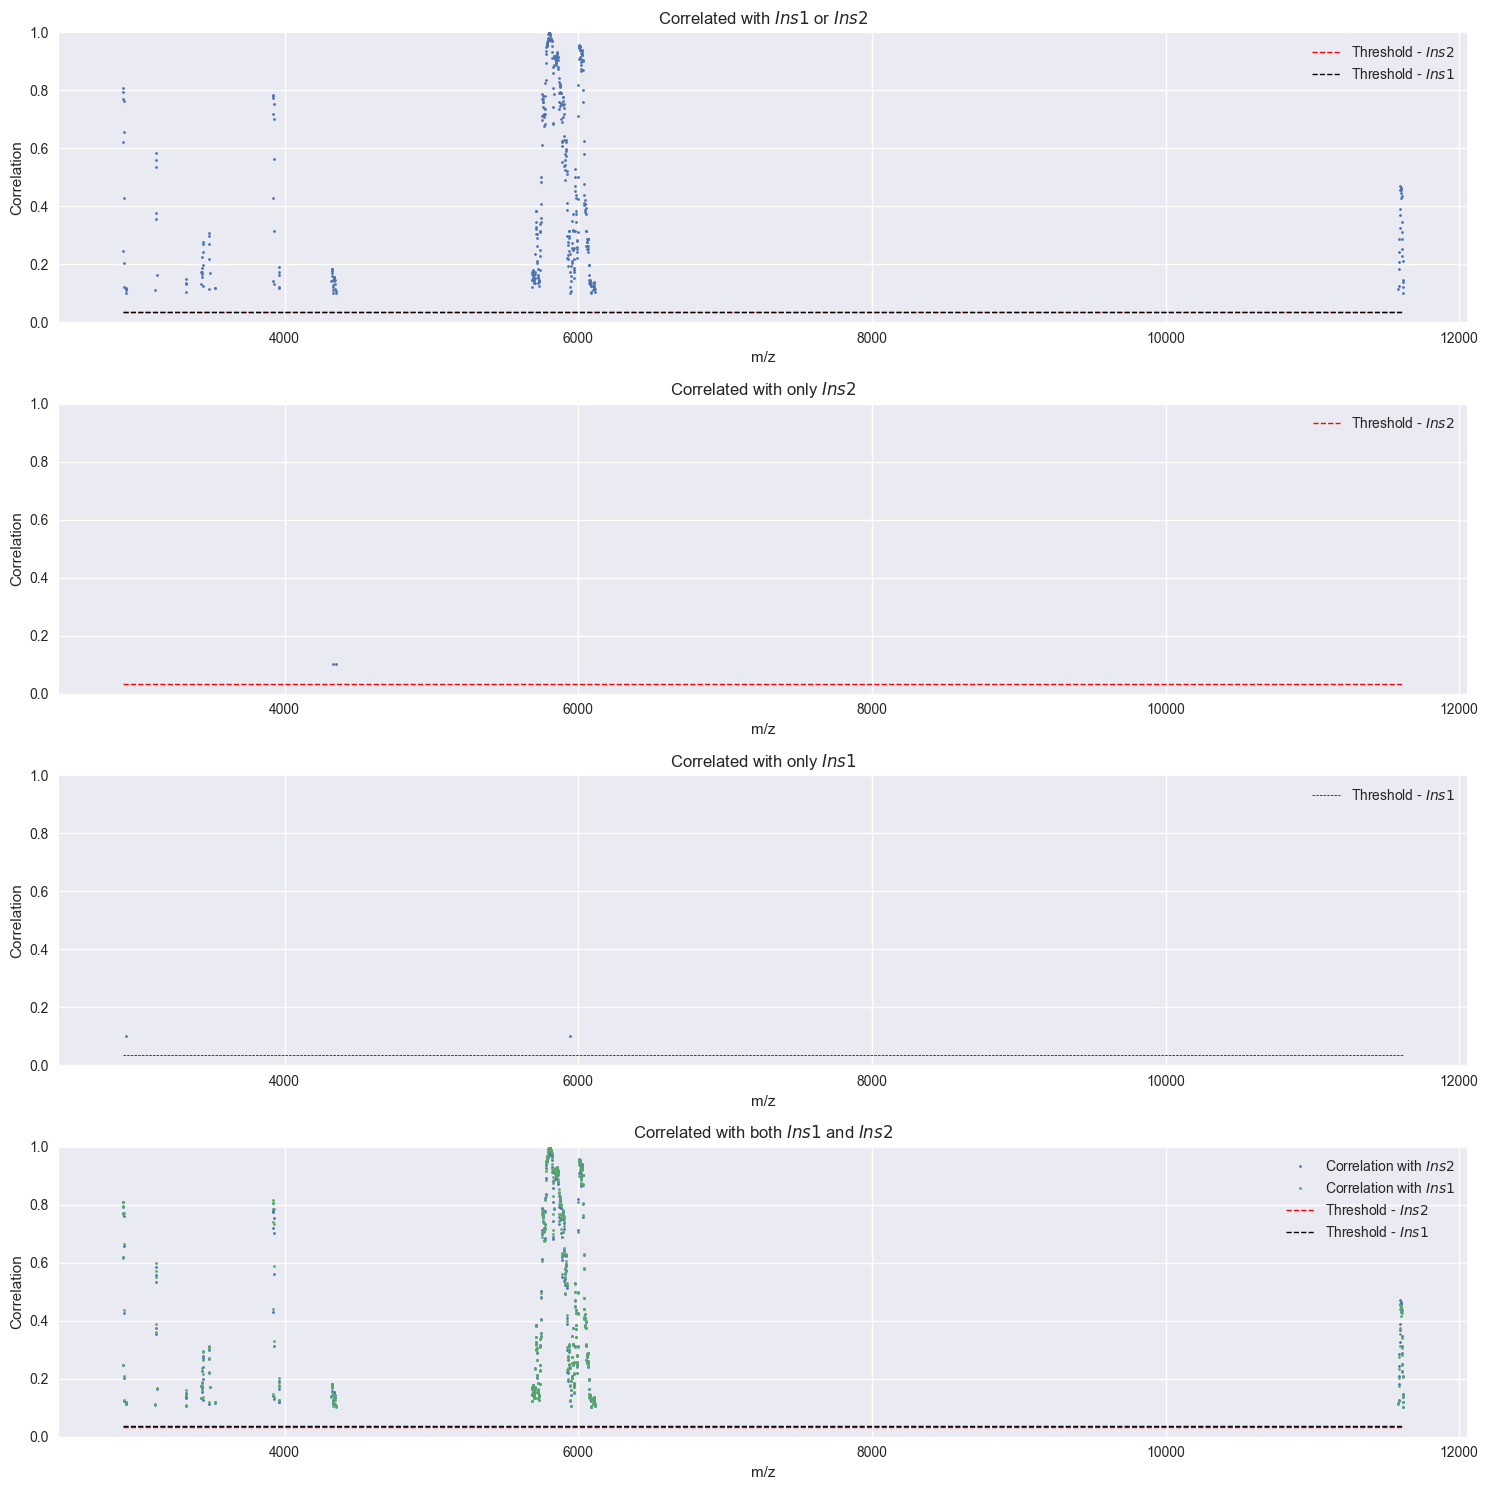

In [25]:
obj.plot_correlated_mz(suptitle = False)

### Figure 4.3

The correlated $m/z$ ratios with $Ins2$. $m/z$ ratios are clustered into 3
groups

/Users/Serkan/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


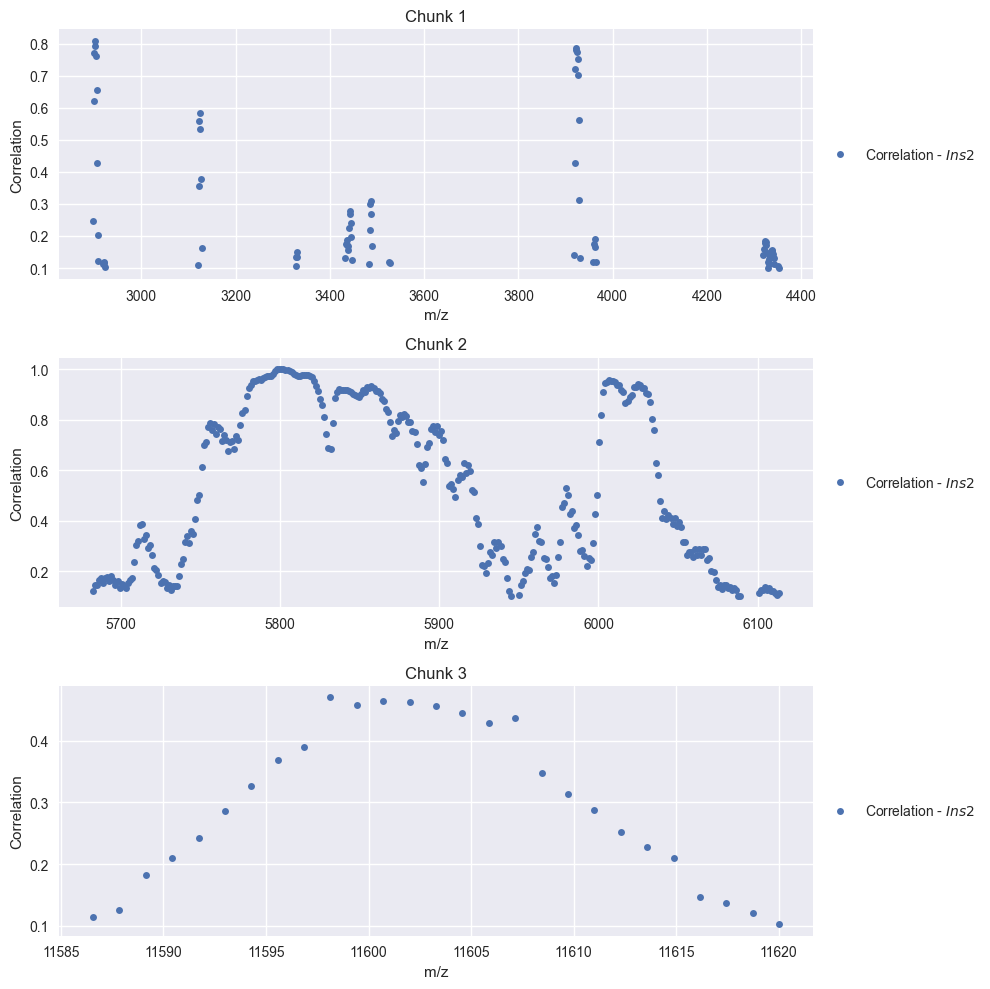

In [26]:
obj.create_clusters(k = 3, plot = True) 

### Figure 4.4

AIC - BIC Scores for Gaussian Mixture Model for all Clusters.
The predicted number of the number of components (indicated by a vertical dashed line)
for each cluster are 5, 4, and 2

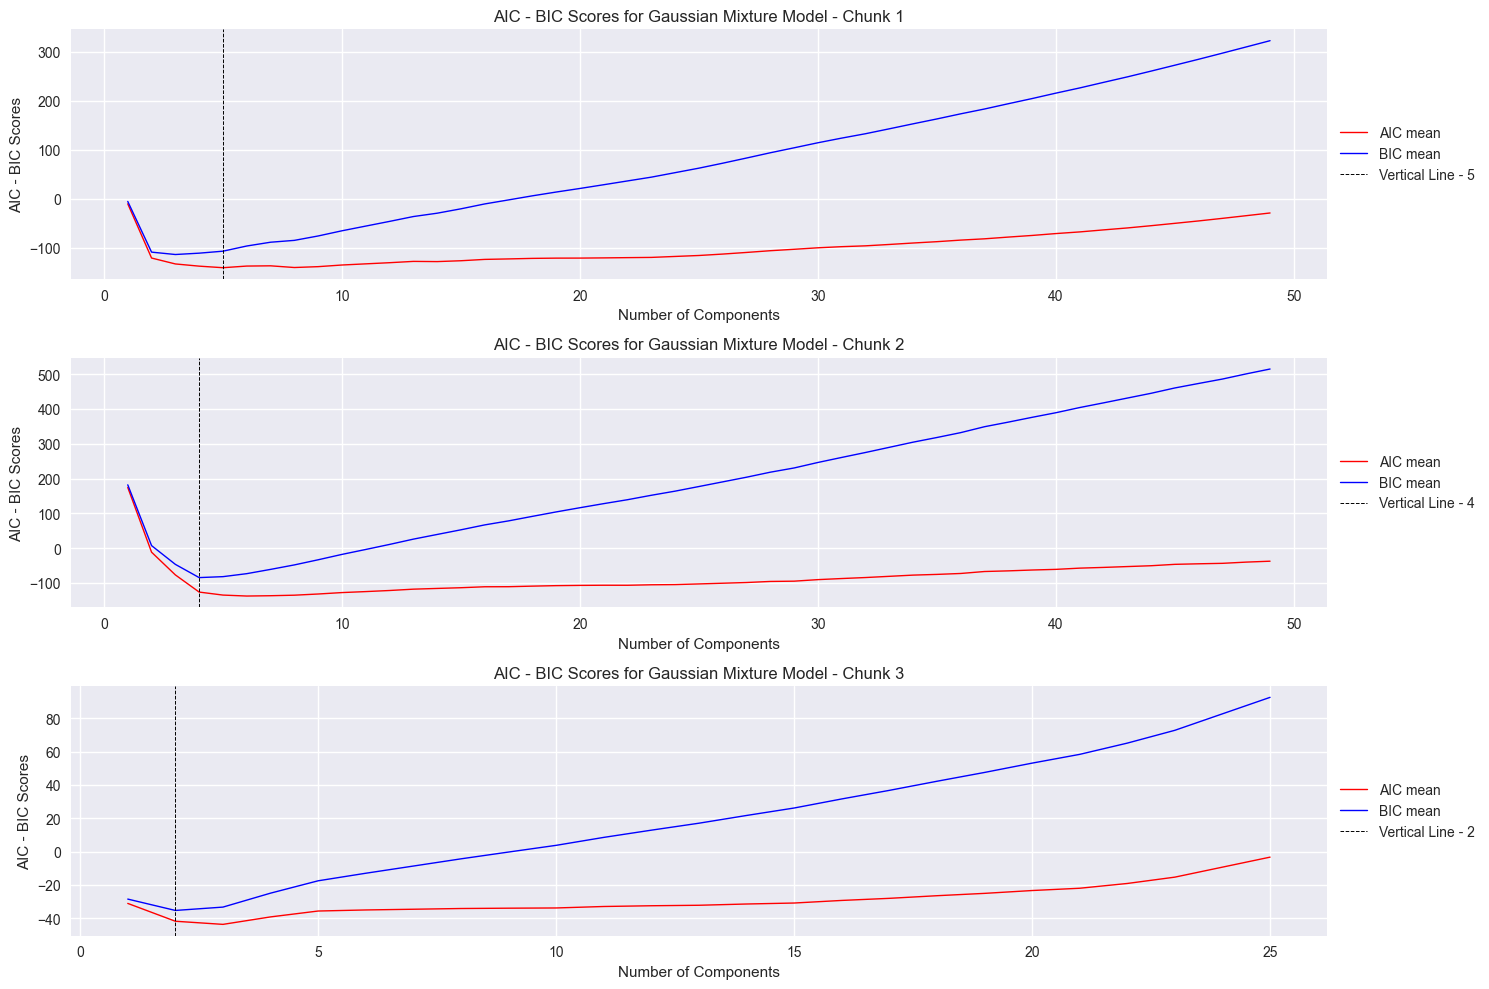

In [39]:
obj.plot_aic_bic_line([5,4,2])

### Figure 4.5

GMMs fitted into the clusters with the given number of compo
nents. The means of the components are labelled with an x and the colour represents
the componen

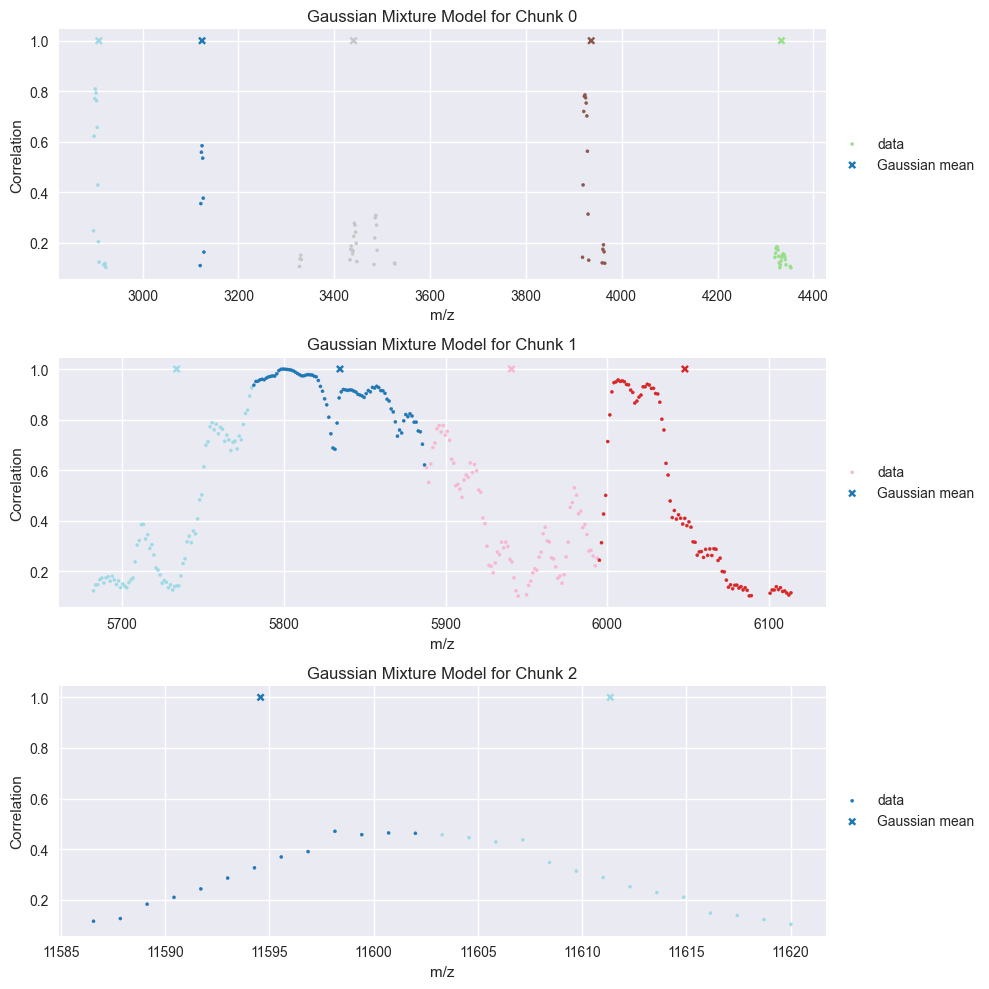

In [40]:
obj.fit_gaussian_mixture(n_components = [5,4,2], plot = True)

### Figure 4.6

Peak Detection Using Savistky Golay filter. Cubic extrapolation is
applied and peak threshold is $10^{-5}$

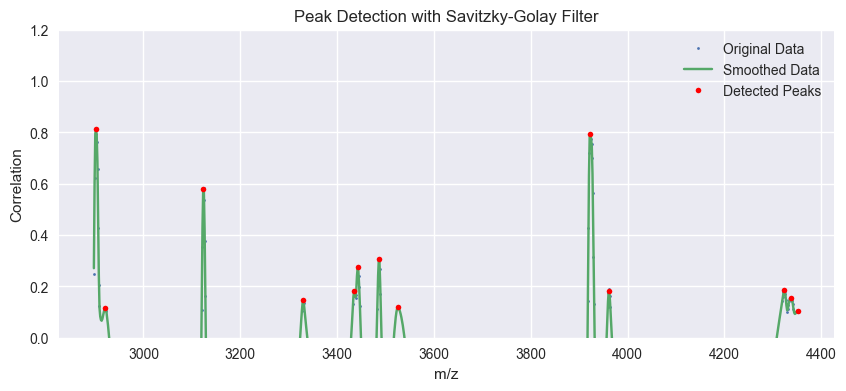

In [34]:
obj.find_peak_filter(chunk = 0, interp1d_kind = 'cubic', filter_window_length = 5, filter_polyorder = 2, 
                     find_peaks_height = 0.1, find_peaks_distance = None, find_peaks_threshold = 0.00001, plot = True)

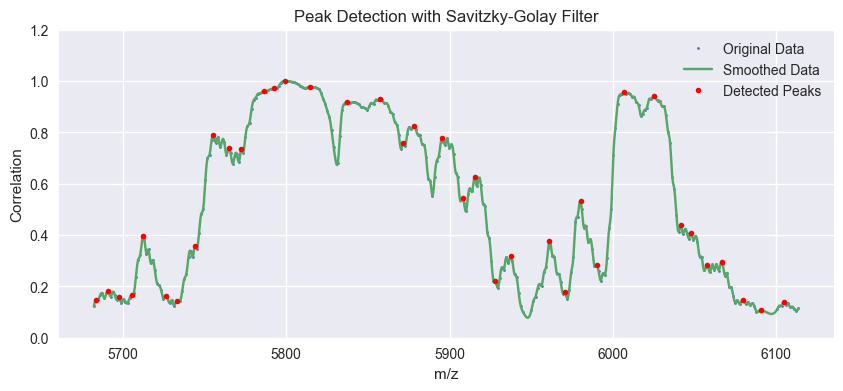

In [35]:
obj.find_peak_filter(chunk = 1, interp1d_kind = 'cubic', filter_window_length = 5, filter_polyorder = 3, 
                     find_peaks_height = 0.1, find_peaks_distance = 15, find_peaks_threshold = 0.00001, plot = True)

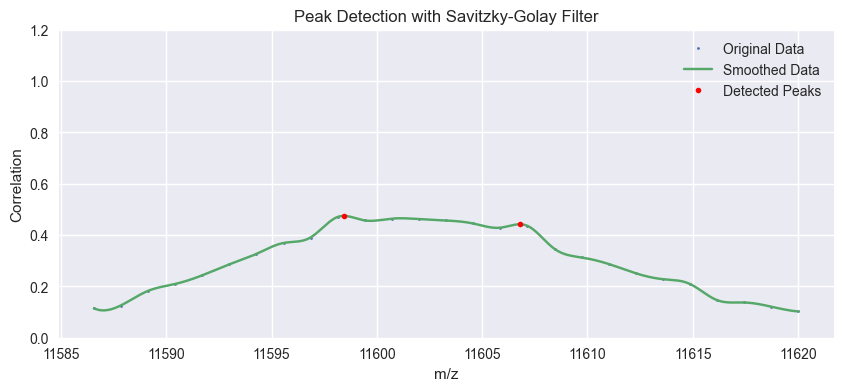

In [36]:
obj.find_peak_filter(chunk = 2, interp1d_kind = 'cubic', filter_window_length = 10, filter_polyorder = 3, 
                     find_peaks_height = 0.1, find_peaks_distance = None, find_peaks_threshold = 0.00001, plot = True)

### Figure 4.7

GMM Model with the given number of components for each clus-
ter. Colour represents the component which the data is drawn from

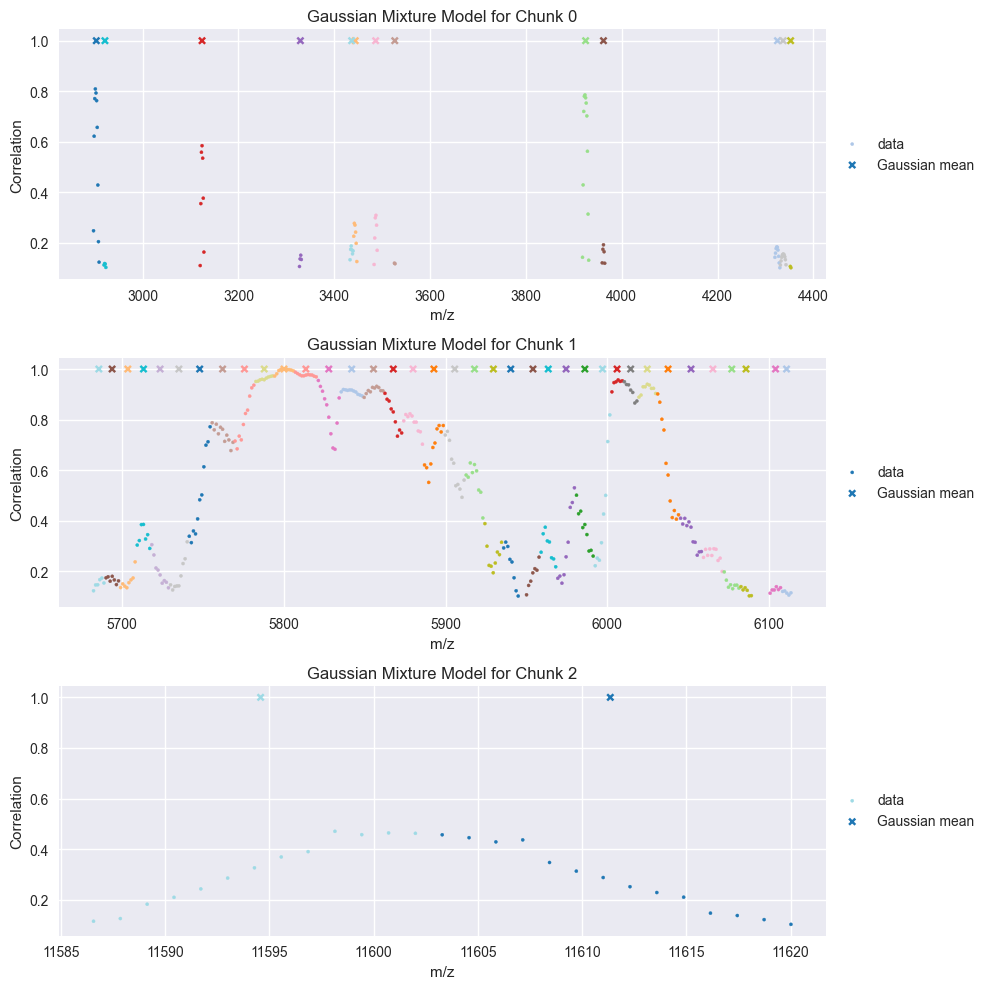

In [41]:
obj.fit_gaussian_mixture(n_components = [13,37,2], plot = True)

### Figure 4.8

GMM Model with the given number of components and given
means for each cluster. Colour represents the component which the data is drawn
from.


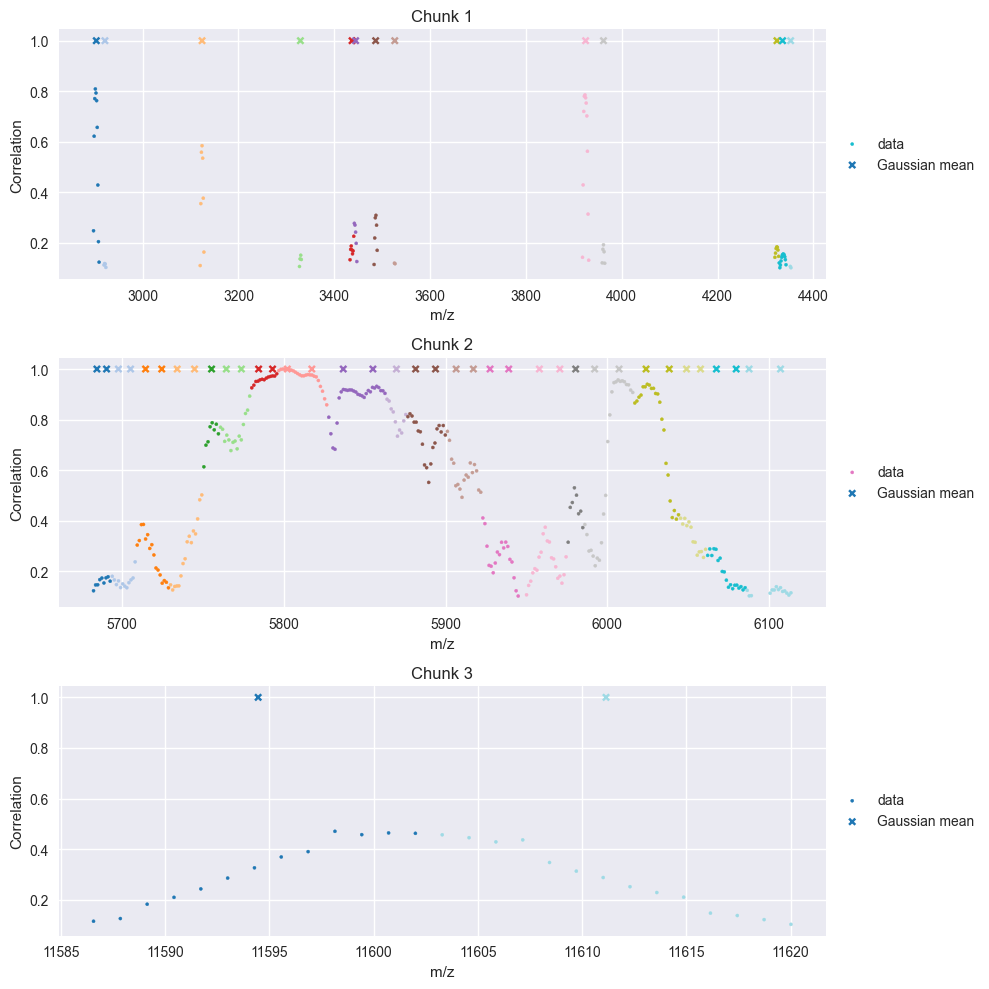

In [45]:
obj.plot_known_gaussian_mixture(suptitle=False)

### Figure 4.9

The difference between GMM methods. The means of the GMM
model with pre-determined means (orange) and calculated means (blue).


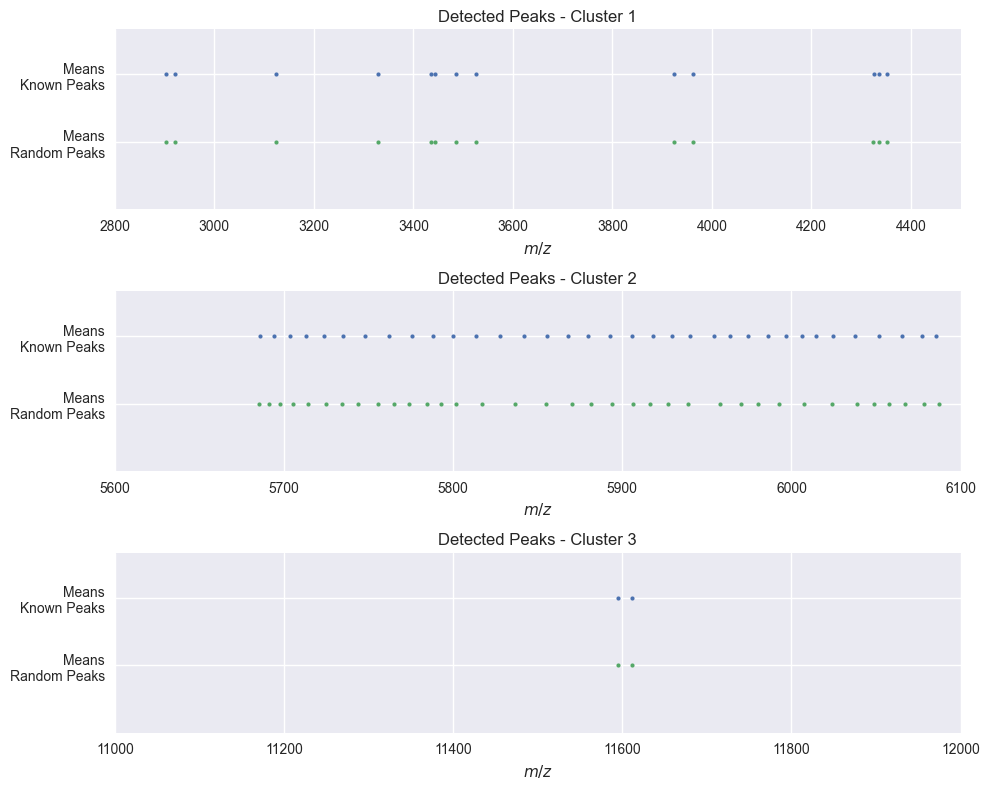

In [47]:
_, _ = return_candidate_peaks(obj, plot = True)

## Chapter 6

### Figure 6.1

The Map of the Islets of Langerhans

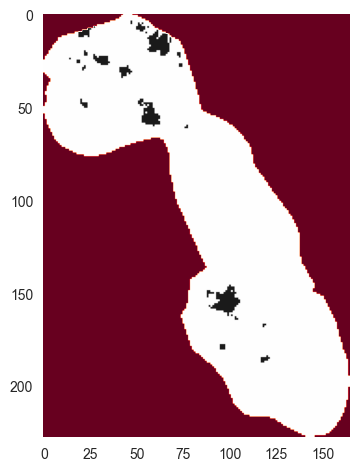

In [66]:
plt.grid(False)
plt.imshow(obj.cluster_map_altered, cmap = 'RdGy')

### Figure 6.2

Example Results of the Hypothesis Test. (a) Accepted example, (b)
Rejected example.

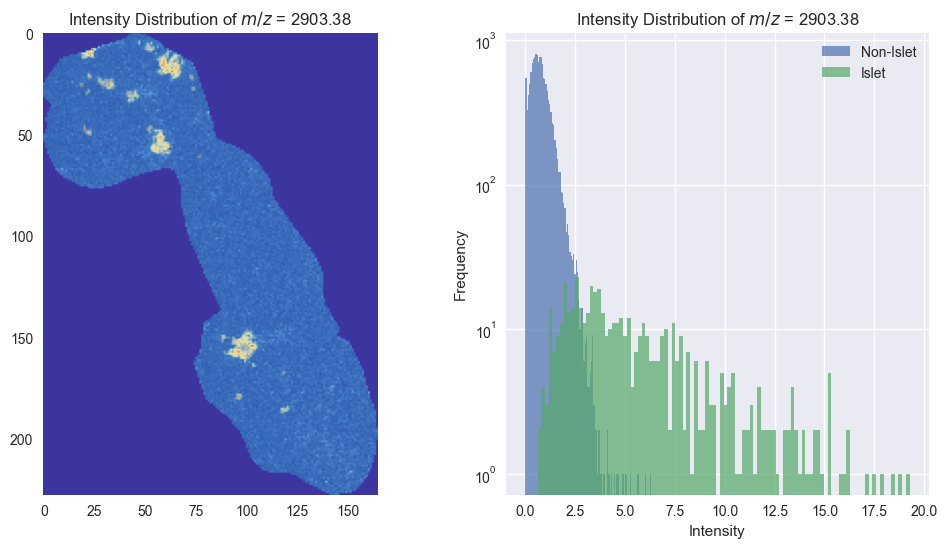

In [69]:
plot_candidate_peak_dist(obj, known_means_gmm_significant, 0)

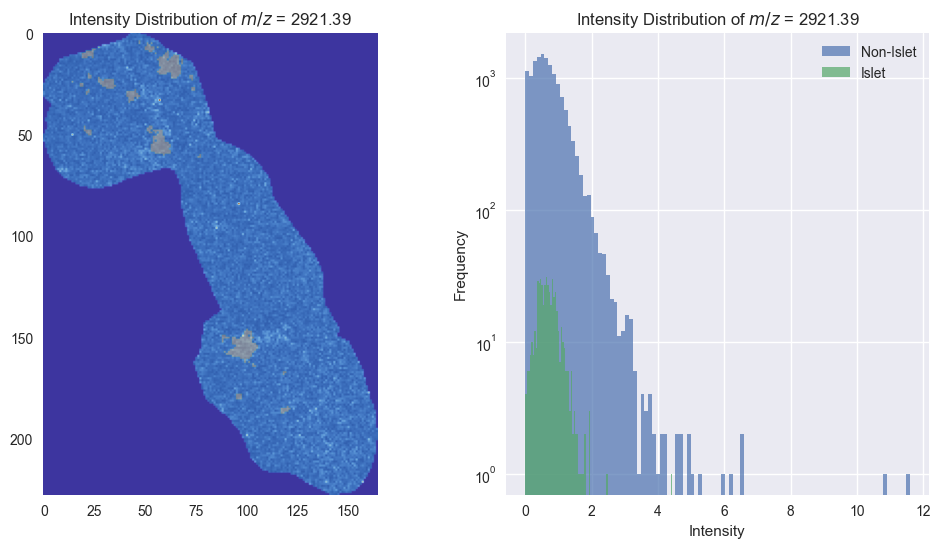

In [71]:
plot_candidate_peak_dist(obj, random_gmm_non_significant, 0)

### Figure 6.3

Significant Insulin Artefact Candidates. The candidates of different
methods are plotted

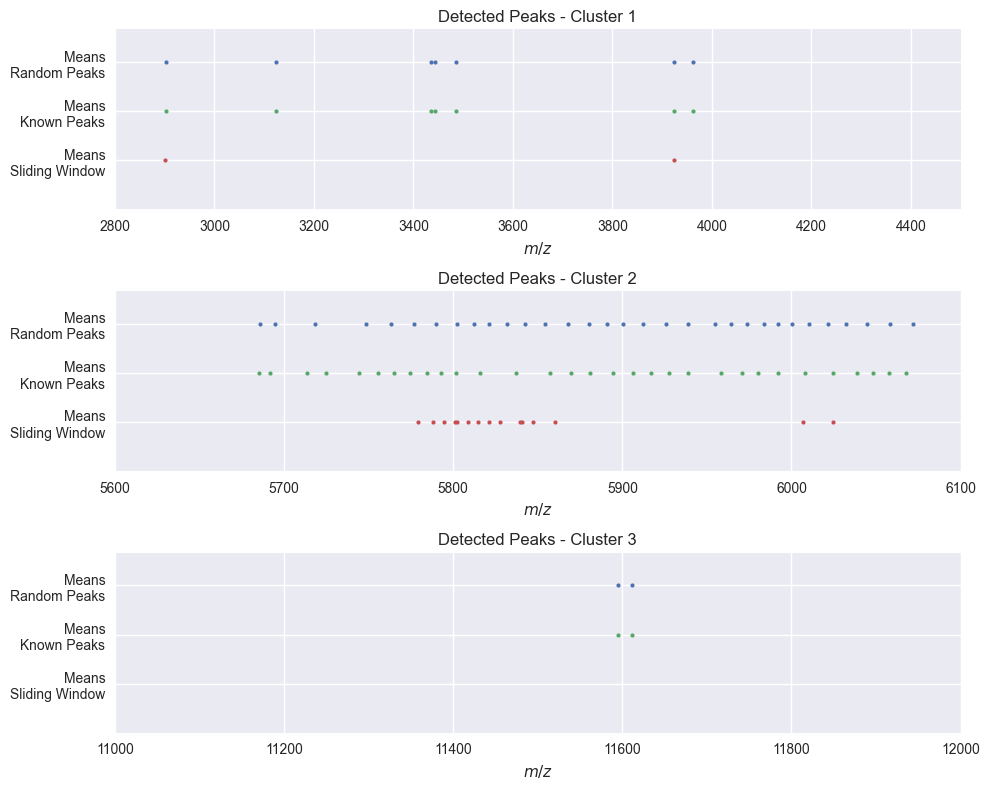

In [42]:
plot_all_candidates(np.array(random_gmm_significant), np.array(known_means_gmm_significant), np.array(sliding_window_candidates_significant))

### Figure 6.4

Common and Unique Candidates Outputted by Different Meth-
ods. Common candidates are outputted by all of the methods and candidates are considered as common if they differ less than 10 m/z

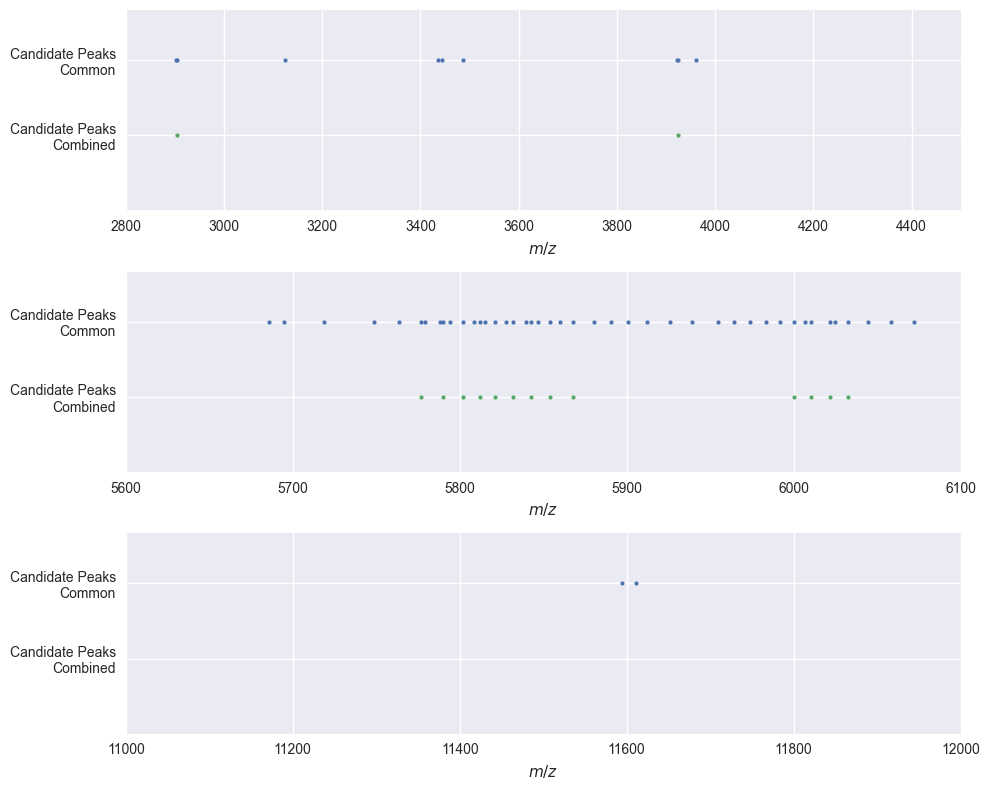

In [43]:
all_candidates = all_candidates.reshape(-1)
final = candidates_final.reshape(-1)

xlim = [[2800, 4500],[5600, 6100], [11000,12000]]
fig, axs = plt.subplots(3, 1,figsize = (10,8))

for i in range(3):
    ax = axs[i]
    ax.plot(all_candidates, np.ones(all_candidates.shape), 'o', label = 'Candidate Peaks\nCombined', ms = 3)
    ax.plot(final, np.ones(final.shape) - 0.15, 'o', label = 'Candidate Peaks\nCommon', ms = 3)
    ax.set_xlabel('$m/z$')
    ax.set_xlim(xlim[i])
    ax.set_ylim(0.7, 1.1)
    ax.set_yticks([0.85, 1])
    ax.set_yticklabels(['Candidate Peaks\nCombined', 'Candidate Peaks\nCommon'])
plt.tight_layout()
plt.show()

### Figure 6.5

UMAP Analyisis of Original Data. Each point is a pixel and colours
represent the clusters assigned in Chapter 3: Cyan (2) represents the islets. The area of
interest (AoI) is labelled different than the neighbouring pixels

even though I applied npr.seed(), it gives different location?

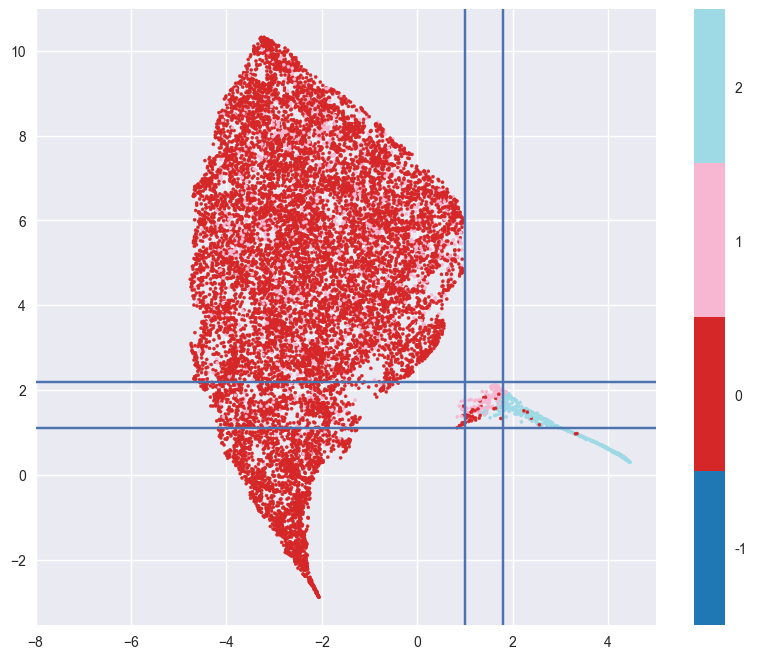

In [45]:
unusual_map = plot_umap_all(obj, embedding, labels) 

### Figure 6.6

The Mean Intensity of AoI. AoI has different distribution than the islet
and non-islet

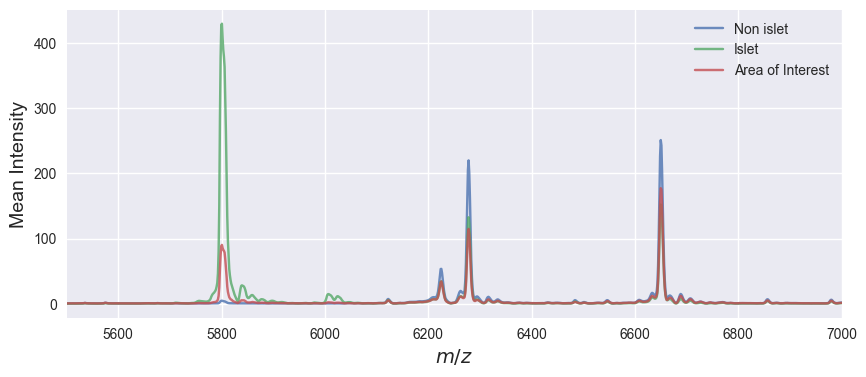

In [92]:
compare_unusual_umap_part(obj, unusual_map)

### Figure 6.7

The Distribution of the Pixels within the AoI. The islets are high-
lighted with red and the AoI is distributed surrounding the islets.

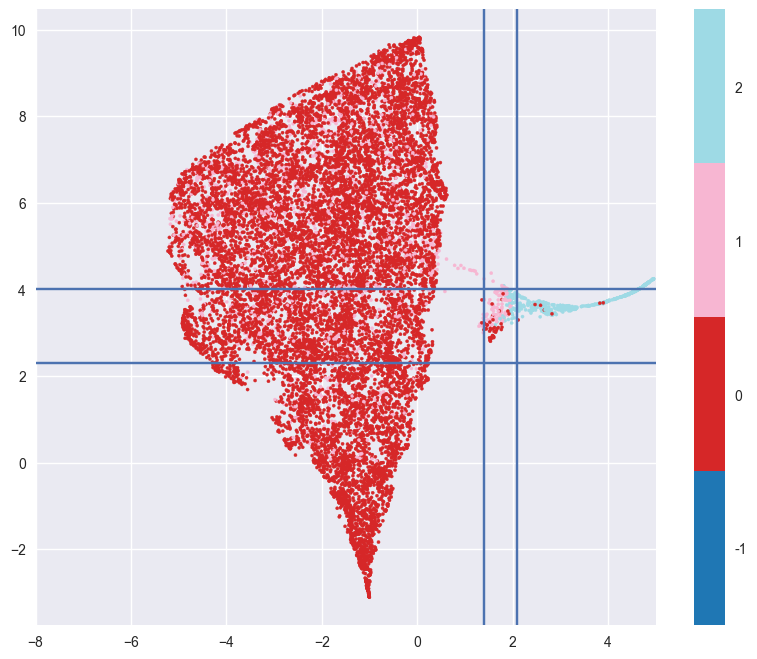

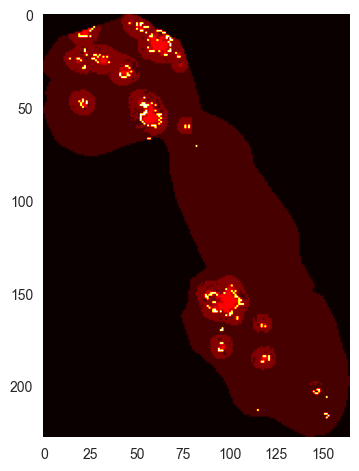

In [104]:
data_all = obj.data.copy()
data_all = data_all.reshape(14000,-1).T
np.random.seed(0)
redu = umap.UMAP(n_components = 2)
embedding_all = redu.fit_transform(data_all)
area_x = (1.4, 2.1)
area_y = (2.3, 4)
labels = obj.cluster_map.reshape(-1)
weird_map = plot_umap_all(obj, embedding_all, labels, area_x = area_x, area_y = area_y)
embedding_all_new = np.zeros((embedding_all.shape[0], 3))
embedding_all_new[:, 0] = embedding_all[:, 0]
embedding_all_new[:, 1] = embedding_all[:, 1]
labs = obj.cluster_map.copy()
labs[weird_map] = 10
plt.grid(False)
plt.imshow(labs, cmap='hot')

### Figure 6.8

UMAP Analysis of MSI Data. (1) Analysis is applied to all data, (2)
analysis is applied to the non-islet data

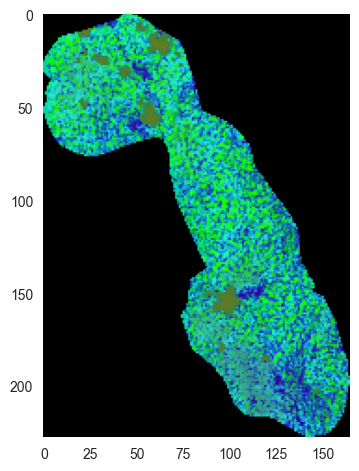

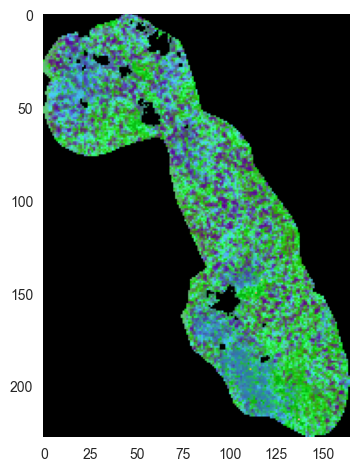

In [105]:
umap_all, umap_non = umap_non_islet(obj, plot = True)

### Figure 6.9

Detected Insulin-Artefact GMM Components. (a) The correlation
of the m/z ratios, (b) The mean intensity of the m/z ratios

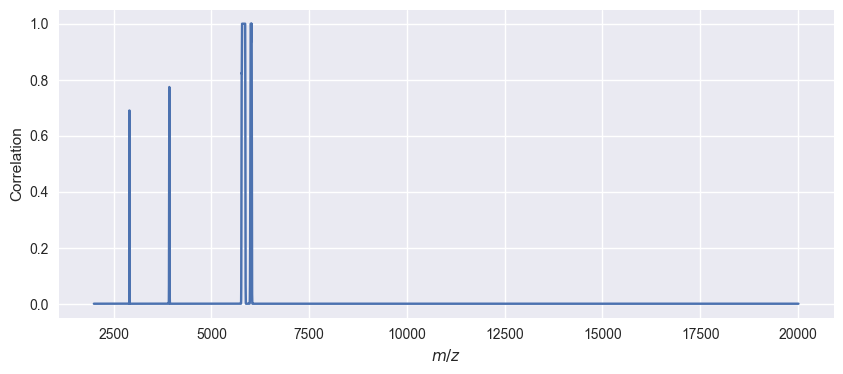

In [98]:
_ = calculate_correlated_distributions(obj, candidates_final, plot = True)

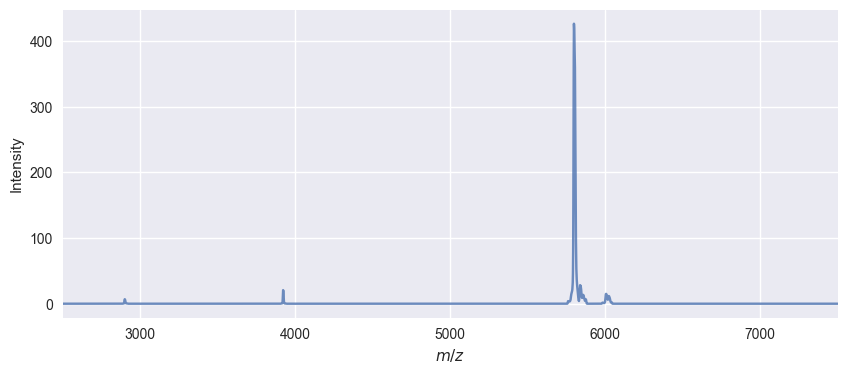

In [96]:
insulin_artefacts_mean = np.mean(islet_original, axis = 1) -  np.mean(islet_removed, axis = 1)
plt.figure(figsize = (10,4))
plt.plot(obj.mz_vector, insulin_artefacts_mean, label = 'Artefacts', alpha = 0.8)
plt.xlabel('$m/z$')
plt.ylabel('Intensity')
plt.xlim(2500,7500)
plt.show()

### Figure 6.10

The effect of Artefact Removal on UMAP Analysis. Datapoints
represent pixels. (a) UMAP analysis on original islet data, (b) UMAP analysis on reduced
islet data

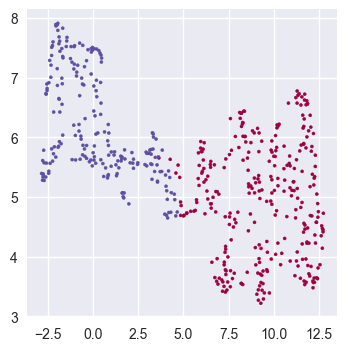

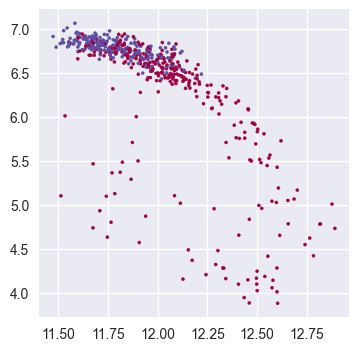

In [93]:
plot_umap_islet(islet_pixel_original, islet_pixel_removed, islet_pixel_label, pixel = True)